Simple script to fetch all the latest measurement probe data in Africa, create seperate csv files per country, and cocatenate into a single csv file.

***This notebook, and csv files must be in the same directory***

***Delete all the csv files in the directory if you need to run this script again***

In [10]:
import requests
import json
from pandas.io.json import json_normalize 
import time
from datetime import date
import pandas as pd
import _thread
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib as mpl
from datetime import datetime
import numpy as np
import csv
import os
import glob


os.chdir('/home/tunde/GIT_PROJECTS/RIPE_ANALYSIS/African_Probes_Status')

%matplotlib inline

#set ggplot style
plt.style.use('default')
plt.rcParams.update({'font.size': 14})

ATLAS_PROBES_URI = "https://stat.ripe.net/data/atlas-probes/data.json?resource="
ATLAS_DEPLOYMENT_URI = "https://stat.ripe.net/data/atlas-probe-deployment/data.json?resource="

ccs = [
'EG', 'BJ', 'CI', 'CV', 'GH', 'GM', 'GN', 'GW', 'AO', 'CF', 'CG', 'CM', 'GA', 'GQ', 'TD', 'BI', 'DJ', 'ER', 'ET', 'KM', 'BW', 'MA', 'SD', 'TN', 'LR', 'ML', 'MR', 'NE', 'NG', 'SL', 'SN', 'TG', 'ST', 'KE', 'MG', 'MU', 'MW', 'MZ', 'RE', 'RW', 'SC', 'SO', 'UG', 'LS', 'NA', 'SZ', 'ZA', 'DZ', 'EH', 'LY', 'BF', 'SH', 'CD', 'TZ', 'YT', 'ZM', 'ZW']

## Function to get probe status per country and create a seperate csv file per country in the list ***ccs*** above

In [5]:
def getDeployment(cc):
    
    test_url = ATLAS_DEPLOYMENT_URI + cc
    
    df = pd.DataFrame()
    
    try:
        r = requests.get(test_url)
    except requests.exceptions.RequestException as e:
        return "Request FAILED"
    
    try:
        data = json.loads(r.text)['data']['deployments'][0]['deployment']
        df = json_normalize(data)
        df['cc'] = cc
    except KeyError as e:
        pass
    
    return df

## Change directory and generate probe data for each individual country in Africa

In [ ]:
for cc in ccs:
        os.chdir('/home/tunde/GIT_PROJECTS/RIPE_ANALYSIS/African_Probes_Status/csv_data_files')
        print(cc)
        a = getDeployment(cc)
        a.to_csv('getDep__'+ cc +'__latest_deployments.csv')

## Merge the csv files created above


In [8]:
extension = 'csv'

os.chdir('/home/tunde/GIT_PROJECTS/RIPE_ANALYSIS/African_Probes_Status/csv_data_files')

all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

#export to csv
combined_csv.to_csv( "2020_africa_probes_deployment.csv", index=False, encoding='utf-8-sig')

print('csv files successfully merged')

csv files successfully merged


In [ ]:
df = pd.read_csv('/home/tunde/GIT_PROJECTS/RIPE_ANALYSIS/African_Probes_Status/csv_data_files/2020_africa_probes_deployment.csv')
#df = df.iloc[:,[0,1,2,3,4,5,6]]
df.head(5)

## Rename the columns and confirm

In [15]:
df = pd.read_csv('/home/tunde/GIT_PROJECTS/RIPE_ANALYSIS/African_Probes_Status/csv_data_files/2020_africa_probes_deployment.csv')
df.rename(columns = {'statuses.abandoned': 'abandoned', 'statuses.connected': 'connected', 'statuses.disconnected': 'disconnected', 'statuses.neverseen': 'neverseen'}, inplace = True)
df.drop('Unnamed: 0', axis='columns', inplace=True)
df = df.iloc[:,[0,1,2,3,4,5,]]
df.head()

,date,abandoned,connected,disconnected,neverseen,cc
0,2020-10-20,7.0,1.0,0.0,3.0,CD
1,2020-10-19,7.0,1.0,0.0,3.0,CD
2,2020-10-18,7.0,1.0,0.0,3.0,CD
3,2020-10-17,7.0,1.0,0.0,3.0,CD
4,2020-10-16,7.0,1.0,0.0,3.0,CD


## Group by date and reset index

In [16]:
df_agg = df.groupby(['date'])['neverseen', 'abandoned','connected','disconnected'].sum().reset_index()
#df_agg.set_index('date')
df_agg.tail()
#df_agg.shape

,date,neverseen,abandoned,connected,disconnected
2303,2020-10-17,108.0,749.0,210.0,57.0
2304,2020-10-18,108.0,749.0,210.0,57.0
2305,2020-10-19,108.0,749.0,207.0,60.0
2306,2020-10-20,108.0,749.0,199.0,68.0
2307,2020-10-20T00:00:00,0.0,0.0,0.0,0.0


## We group the rows by date and sum the statuses before plotting

## Let's split and re-merge the dataframes

In [17]:
df_neverseen = df_agg.iloc[:,[0,1]]
df_neverseen.columns = ['date','amount']
df_neverseen= df_neverseen.assign(type = 'neverseen')

df_abandoned = df_agg.iloc[:,[0,2]]
df_abandoned.columns = ['date','amount']
df_abandoned = df_abandoned.assign(type = 'abandoned')

df_connected = df_agg.iloc[:,[0,3]]
df_connected.columns = ['date','amount']
df_connected = df_connected.assign(type = 'connected')

df_disconnected = df_agg.iloc[:,[0,4]]
df_disconnected.columns = ['date','amount']
df_disconnected = df_disconnected.assign(type = 'disconnected')

df_agg2 = pd.concat([df_neverseen, df_abandoned, df_connected, df_disconnected])
#df_agg2.set_index('date', inplace=True)
df_agg2.head()

,date,amount,type
0,2014-01-01T00:00:00,0.0,neverseen
1,2014-06-13,0.0,neverseen
2,2014-06-14,0.0,neverseen
3,2014-06-15,0.0,neverseen
4,2014-06-16,0.0,neverseen


## Plot

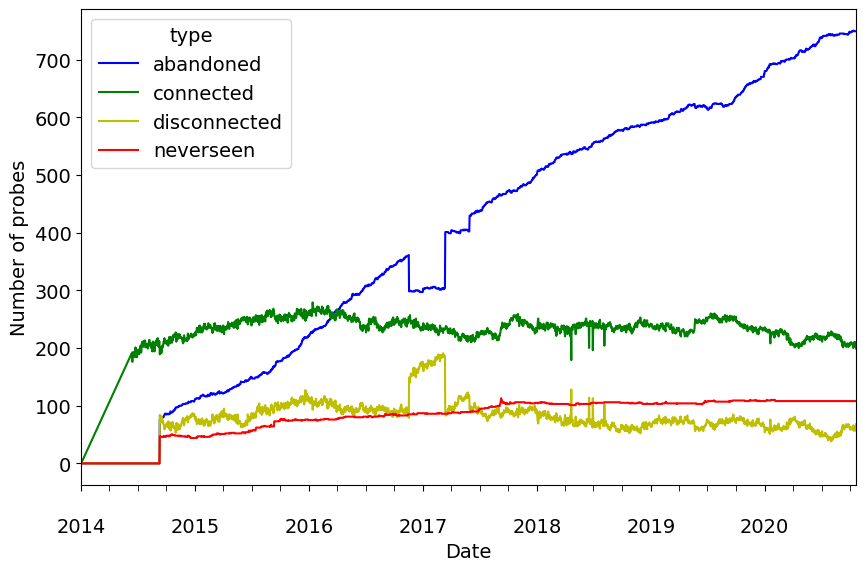

In [18]:
# plot data
fig, ax = plt.subplots(figsize=(10,7))
# use unstack()
df_agg2.date = pd.to_datetime(df_agg2['date'], format='%Y-%m-%d')

styles = ['b','g','y', 'r']

df_agg2.groupby(['date','type']).sum()['amount'].unstack()

df_agg2.groupby(['date','type']).sum()['amount'].unstack().plot(style=styles, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Number of probes')

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator((1,4,7,10)))

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("\n%Y"))
#ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%b"))
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
ax.tick_params(axis="x", which="both", length=4)

plt.tick_params(labelsize=14)
#plt.savefig("data/plots/probes_deployment_timeseries.pdf", bbox_inches="tight")
plt.show()

## Function to get probes 

In [27]:
def getProbes(cc):
    
    test_url = ATLAS_PROBES_URI + cc
    
    df = pd.DataFrame()
    
    try:
        r = requests.get(test_url)
    except requests.exceptions.RequestException as e:
        return "Request FAILED"
    
    try:
        data = json.loads(r.text)['data']['probes']
        df = json_normalize(data)
        df['cc'] = cc
    except KeyError as e:
        pass
    
    return df


## Change directory and generate probe data for each individual country in Africa

In [ ]:
for cc in ccs:
        os.chdir('/home/tunde/GIT_PROJECTS/RIPE_ANALYSIS/African_Probes_Status/csv_data_files_probes')
        print(cc)
        a = getProbes(cc)
        a.to_csv(cc +'__latest_Probe_deployments.csv')

## Merge files

In [29]:
extension = 'csv'

os.chdir('/home/tunde/GIT_PROJECTS/RIPE_ANALYSIS/African_Probes_Status/csv_data_files_probes')

all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

#export to csv
combined_csv.to_csv( "2020_africa_probes.csv", index=False, encoding='utf-8-sig')

print('csv files successfully merged')

csv files successfully merged


/home/tunde/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Geographical Distribution of connected probes

In [36]:
import plotly.graph_objects as go

import pandas as pd

df_Prb = pd.read_csv('/home/tunde/GIT_PROJECTS/RIPE_ANALYSIS/African_Probes_Status/csv_data_files_probes/2020_africa_probes.csv')

fig = go.Figure(data=go.Scattergeo(

        locationmode = 'country names',
        lon = df_Prb[df_Prb['status'] == 1 ]['longitude'],
        lat = df_Prb[df_Prb['status'] == 1 ]['latitude'],
        text = 'Connected',
        mode = 'markers',
        marker = dict(color = 'green')

    

))

fig.update_layout(
        title = 'Probes Distribution in Africa October 2020',
          geo = dict(
            scope='africa',
            projection_type="natural earth",
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
            showlegend=False
    

)
fig.show()
